<a href="https://colab.research.google.com/github/pintophilip/GPTs/blob/main/News_Recommendations_using_OpenAI_Text_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
OpenAI provides text embeddings that can be used to perform text analytics and natural language processing tasks. We will use these embeddings to recommend news articles that are similar to a given news article.

We will accomplish this task in a few steps:
1. Setup
2. Establishing a cache
3. Recommending articles
4. Testing recommendations

## 1. Setup

In this section, we will:
* Install required libraries
* Import libraries and functions
* Load the cleaned data set from Code Interpreter
* Explore the data set

Let's begin by installing the OpenAI library

In [ ]:
# Install openai
!pip install openai==0.28.1

Let's now import the required libraries and functions.

In [ ]:
# Import pickle to serialize the embedding data set for caching
import pickle

# Import the openai library
import openai

# Import pandas to access dataframes
import pandas as pd

# Import required functions from the openai.embeddings_utils module
from openai.embeddings_utils import get_embedding, distances_from_embeddings, indices_of_nearest_neighbors_from_distances

*pickle* is a library that is sometimes used to cache objects. Caching in our context refers to the process in which we save some data on our machines to avoid making repeated calls to the OpenAI API. Pickle is used to convert Python objects into a stream of 1s and 0s and convert these 1s and 0s back to Python objects. This process is called serialization. Once we have serialized a Python object, we can safely store it locally.



Now let's define the model that we are using and load our API key.

In [ ]:
# Save the name of the preferred embedding model in a variable
EMBEDDING_MODEL = 'text-embedding-ada-002'

In [ ]:
# Load the API key
with open('api_key.txt') as f:
    openai.api_key = f.read()

In [ ]:
openai.api_version = '2023-05-15'
openai.api_base = 'https://upgrad-teach-team-resource.openai.azure.com/' # Please add your endpoint here
openai.api_type = 'azure'
with open('azure_api_key.txt') as f:
    key = f.read()
openai.api_key = key
_chat = 'data_content'
_completion = 'YKN_tech_team_deployment'

In [ ]:
# Load the dataset
df = pd.read_csv('/content/news_category_dataset_cleaned.csv')

# Display the first few records of the dataframe
df.head()

,link,headline,category,short_description,authors,date,views,year
0,https://www.huffpost.com/entry/minimum-wage-in...,Millions To See Pay Hikes In 2019 As Minimum W...,U.S. NEWS,Thirteen counties and cities will notice the d...,Amy Russo,2018-12-31,18800.0,2018
1,https://www.huffpost.com/entry/california-wome...,'Overwhelmingly White' California Women's Marc...,U.S. NEWS,Organizers said they would work harder to attr...,Amy Russo,2018-12-31,17292.0,2018
2,https://www.huffpost.com/entry/markets-right-n...,U.S. Stocks Suffer Worst Year Since 2008 Finan...,BUSINESS,"Despite a dismal year, the market closed out 2...","ALEX VEIGA, AP",2018-12-31,29312.0,2018
3,https://www.huffpost.com/entry/louisiana-polic...,Louisiana Police Sucker Media With Offer To 'T...,WEIRD NEWS,The Harahan Police Department's faux Facebook ...,David Lohr,2018-12-31,16858.0,2018
4,https://www.huffpost.com/entry/serena-williams...,Roger Federer Will Face Off With Serena Willia...,SPORTS,The tennis legends will play a mixed doubles m...,Curtis M. Wong,2018-12-31,44243.0,2018


Our data set contains two text columns that can be used for recommendations. To get as much data as we can for our task, we can combine the *headline* and the *short_description*.

In [ ]:
# Combine the two main text columns
df['combined_description'] = df['headline'] + ' ' + df['short_description']

In [ ]:
# Retain only the necessary columns and convert to a list
article_descriptions = df['combined_description'].tolist()

In [ ]:
# Let's look at the first few records in our dataframe now
few = 5
for combined_description in article_descriptions[0:few]:
    print('')
    print('Combined Description: ', combined_description)


Combined Description:  Millions To See Pay Hikes In 2019 As Minimum Wage Increases In 20 States Thirteen counties and cities will notice the difference immediately on January 1, reaching or exceeding $15 an hour.

Combined Description:  'Overwhelmingly White' California Women's March Canceled Over Representation Concerns Organizers said they would work harder to attract participants who reflect the community's diversity.

Combined Description:  U.S. Stocks Suffer Worst Year Since 2008 Financial Crisis Despite a dismal year, the market closed out 2018 on a bright note.

Combined Description:  Louisiana Police Sucker Media With Offer To 'Test' Meth For Zika The Harahan Police Department's faux Facebook post was an "attempt at humor."

Combined Description:  Roger Federer Will Face Off With Serena Williams For The First Time The tennis legends will play a mixed doubles match on New Year's Day at the Hopman Cup in Australia.


In [ ]:
# Check the size of the dataframe
len(article_descriptions)

9476

## 2. Caching
Caching is a proces by which temporary data or information can be stored locally so that they need not be processed again each time the script is executed.

We are caching embeddings because it costs time and money to create API calls to the embeddings model.

For example, the Ada v2 model costs \$0.0001 / 1K tokens.

Consider the first combined description, "Millions To See Pay Hikes In 2019 As Minimum Wage Increases In 20 States Thirteen counties and cities will notice the difference immediately on January 1, reaching or exceeding $15 an hour." This contains 189 characters and 38 tokens.

If we round this up to 40 tokens for each combined description and consider that our data set contains roughly 10,000 data points, we end up calculating embeddings for 400,000 tokens. This means, to calculate embeddings for this data set, we need to spend 4 cents.

A helpful rule of thumb is that one token generally corresponds to ~4 characters of text for common English text.

We will create a pickle file for the embeddings that we create. We will save our embeddings in a dictionary which has:
* A tuple (text, model) as keys
* The embedding vector as value

We will define a function that returns the embedding for a given piece of text from the cache. If the embedding is not available in the cache, this function makes a call to the OpenAI embeddings API to retrieve the embedding for that text and adds it to the cache.

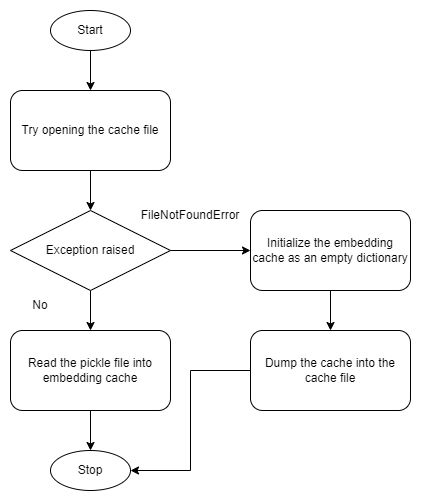

In [ ]:
# Establish a cache of embeddings to avoid recomputing
# The cache is a dict where the key is a tuple (text, model) and the embedding is the value saved as a pickle file

# Set the path to the embedding cache
embedding_cache_path = '/content/recommendations_embeddings_cache.pkl'

# Load the cache if it exists and save a copy to disk
try:
    # If the cache file exists, read it
    embedding_cache = pd.read_pickle(embedding_cache_path)
except FileNotFoundError:
    embedding_cache = {}
    # If the cache file does not exists, initialize it with an empty dictionary
    with open(embedding_cache_path, 'wb') as embedding_cache_file:
        pickle.dump(embedding_cache, embedding_cache_file)

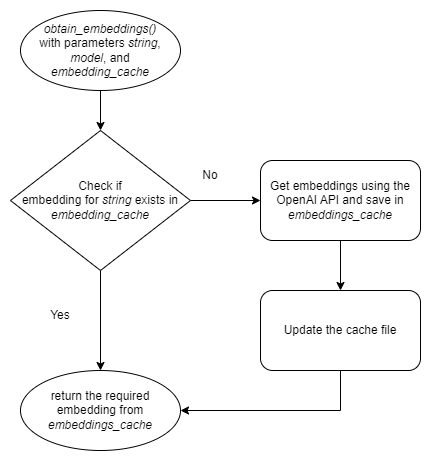

In [ ]:
# Define a function to retrieve embeddings from the cache if present, otherwise request via the API
# Note: If the cache file does not have the embedding, we create it using OpenAI and update the cache as well
def obtain_embeddings(string = None, model = EMBEDDING_MODEL, embedding_cache = embedding_cache):
    """Return embedding of given string using a cache if possible to avoid recomputing.
    If the embedding for the string does not exist in the cache file, update the cache with embeddings from OpenAI."""
    if (string, model) not in embedding_cache.keys():
        # Note: The 'get_embedding' method is from OpenAI's embedding utilities
        embedding_cache[(string, model)] = get_embedding(string, model)
        # Update the cache file with the new cache
        with open(embedding_cache_path, 'wb') as embedding_cache_file:
            pickle.dump(embedding_cache, embedding_cache_file)
    return embedding_cache[(string, model)]

In [ ]:
# Consider the first record in the dataset for example
example_string = article_descriptions[0]
print('Example string: ', example_string)

# Print the first few dimensions of the retrieved embedding
few = 2
example_embedding = obtain_embeddings(example_string)
print('Corresponding embedding: {} ...'.format(example_embedding[:few]))

Example string:  Millions To See Pay Hikes In 2019 As Minimum Wage Increases In 20 States Thirteen counties and cities will notice the difference immediately on January 1, reaching or exceeding $15 an hour.
Corresponding embedding: [-0.008858582936227322, -0.02650456875562668] ...


In [ ]:
# Check the dimensionality of the embeddings
len(example_embedding)

1536

An OpenAI embedding is a float vector that has 1536 dimensions. Now that we have defined a function to obtain embeddings and have incorporated our cache in this functionality, we can move on to working on our recommendation engine.

## 3. Recommending articles
We will now define a function that takes in the original corpus of text, the query string, the number of recommendations that we want, and the embedding model that we're using, and returns news recommendations.

In [ ]:
def shrewdnewsAI(strings = None, query_string_index = None, K = 1, model = EMBEDDING_MODEL):
    """Print out the K nearest neighbors of a given string."""
    # Obtain the embeddings for all the records in the source corpus
    embeddings = [obtain_embeddings(string, model = model) for string in strings]

    # Obtain the embedding of the query string
    query_embedding = embeddings[query_string_index]

    # Obtain distances between the query embedding and other embeddings using the 'distances_from_embeddings' method
    # Note: This is a method from OpenAI's embedding utilities
    # Note: Other similarity metrics may be used
    distances = distances_from_embeddings(query_embedding, embeddings, distance_metric = 'cosine')

    # Obtain indices of nearest neighbors using the 'indices_of_nearest_neighbors_from_distances' method
    # Note: This is a method from OpenAI's embedding utilities
    # Note: Other logics may be used for decision-making based on similarity scores
    indices_of_nearest_neighbors = indices_of_nearest_neighbors_from_distances(distances)

    # Print the query string
    query_string = strings[query_string_index]
    print('Query string: ', query_string)

    # Print the K nearest neighbours to the query string
    k_counter = 0
    for i in indices_of_nearest_neighbors:
        k_counter = k_counter + 1

        # Skip any strings that are identical matches to the query string
        if query_string == strings[i]:
            continue
        # Stop after printing out K articles
        if k_counter > K + 1:
            break

        # Print the similar strings
        print('Recommendation {x}: {y}'.format(x = k_counter - 1, y = strings[i]))

    return None

Obtaining embeddings for the first time may take some time as you are doing a lot of API calls, but we have the embeddings cached, so it gets done quickly. A better way to do this would be to use a vector database. That allows you to save and query embeddings much quicker.

## 4. Testing

We can test our model by printing recommendations for a few articles.

In [ ]:
# Print the top 5 similar news article that are similar to the article in index 0 in the corpus
shrewdnewsAI(strings = article_descriptions,
             query_string_index = 0,
             K = 5)

Query string:  Millions To See Pay Hikes In 2019 As Minimum Wage Increases In 20 States Thirteen counties and cities will notice the difference immediately on January 1, reaching or exceeding $15 an hour.
Recommendation 1: Hundreds Protest In Cities Across U.S. For 'Poor People's Campaign' The movement demands lawmakers do more to help Americans in poverty, from supporting a $15 minimum wage to ending systemic racism.
Recommendation 2: Paul Ryan: Secretary Getting $1.50 More A Week Shows Effect Of GOP Tax Cuts Not exactly a winning sales pitch.
Recommendation 3: Companies Are Disclosing How Much Less They Pay Workers Than Executives And some firms seem a little embarrassed.
Recommendation 4: Tentative Deal Reached To End West Virginia Teacher Strike Teachers will get a 5 percent raise, and state employees will get a 3 percent raise. But there's no clear fix to the employee health care plan.
Recommendation 5: Most Americans Can't Afford A Minor Emergency Just 39 percent of Americans hav